![title](images/header.png)
# VI - Calculating areas of change and confidence intervals
-------
This notebook estimates of areas of change for all categories using the entire database of systematic points, and calculates the margin of error based on the visually interpreted data 
This script requires a m4 instance
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

### 1 - Read files and set parameters
read the output merged file with the classification of all eSBAE points from script 5e

In [2]:
#GAB
df = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_supervised_class_1522.csv', low_memory=False)
#DRC
#df = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_supervised_class_1522.csv', low_memory=False)
#with provinces
#df = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_supervised_class_1522_terr.csv', low_memory=False)
#COG
#df = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_supervised_class_1522.csv', low_memory=False)
#CMR
#df = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_esbae_supervised_class_1522.csv', low_memory=False)
#EQG
#df = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_esbae_supervised_class_1522.csv', low_memory=False)
#CAR
#df = pd.read_csv('/home/sepal-user/module_results/esbae/CAR/CAR_esbae_supervised_class_1522.csv', low_memory=False)

In [3]:
pd.pivot_table(df,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['stratum'],aggfunc="count")

stratum,1,2,3
Sim_CEO_Ref_Change_Year_1522,,,
Def2016,NaN,29.0,224.0
Def2017,2.0,9.0,143.0
Def2018,NaN,9.0,126.0
Def2019,NaN,5.0,120.0
Def2020,NaN,13.0,113.0
Def2021,NaN,15.0,114.0
Def2022,2.0,41.0,243.0
Deg2016,1.0,6.0,75.0
Deg2017,1.0,1.0,143.0


In [4]:
#pd.pivot_table(df,values='point_id',index=['Province'],columns=['interpreted'],aggfunc="count")

In [5]:
print(df.columns.values)

['Unnamed: 0' 'images' 'mon_images' 'bfast_change_date' 'bfast_magnitude'
 'bfast_means' 'cusum_change_date' 'cusum_confidence' 'cusum_magnitude'
 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean' 'nir_sd' 'nir_min'
 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min' 'swir1_max' 'swir2_mean'
 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean' 'ndfi_sd' 'ndfi_min'
 'ndfi_max' 'brightness_mean' 'brightness_sd' 'brightness_min'
 'brightness_max' 'greenness_mean' 'greenness_sd' 'greenness_min'
 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min' 'wetness_max'
 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ewma_jrc_date' 'ewma_jrc_change' 'ewma_jrc_magnitude' 'mosum_jrc_date'
 'mosum_jrc_change' 'mosum_jrc_magnitude' 'cusum_jrc_date'
 'cusum_jrc_change' 'cusum_jrc_magnitude' 'ccdc_change_date'
 'ccdc_magnitude' 'aspect' 'dw_class_mode' 'dw_tree_prob__max'
 'dw_tree_prob__min' 'dw_tree_prob__stdDev' 'dw_tree_prob_mean'
 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17' 'esri_lc18' 

In [6]:
print(len(df))

222878


In [7]:
# use these strata counts for area estimation with Excel
strata_counts = df['stratum'].value_counts().sort_index()
print(strata_counts)

stratum
1    122764
2     78802
3     21312
Name: count, dtype: int64


In [8]:
pd.pivot_table(df,values='point_id',index=['interpreted'],columns=['stratum'],aggfunc="count")

stratum,1,2,3
interpreted,,,
0,120851,74983,18671
1,1913,3819,2641


In [9]:
def calculate_areas(db_total, strata_column, categories_column, interpretation_column, total_area, z_score):
    #total database all eSBAE points
    df_full = db_total.copy()
    # only CEO interpreted points
    df_interpreted = db_total[db_total[interpretation_column]==1]
    df_4calc       = db_total[~db_total[categories_column].isna()]
    
    # get all attributes
    categories = df_4calc[categories_column].unique()
    
    # get strata
    strata, d = df_4calc[strata_column].unique(), {}
    print(categories)
    # create stats for each entry
    for category in categories:
        
        if str(category) == 'nan':
            continue
            
        print(f' Calculating stats for {category}')
        # create binary class column
        df_4calc[category] =  df_4calc[categories_column].apply(lambda x: 1 if x == category else 0)
        df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)
        
        print(f'We use {df_4calc[category].sum()} entries for area calculation of {category} in {categories_column}.')
        print(f'We use {df_interpreted[category].sum()} entries for margin of error calculation of {category} in {categories_column}.')
        
        # initialize variables for category <> check the catergories > def, deg, gain
        categories_area, se_total = 0, 0
        d2 = {}
        for stratum in strata:
                        
            if str(stratum) == 'nan':
                continue
            
            # subset to stratum
            df_stratum = df_full[df_full[strata_column] == stratum]
            
            # get area proportion for that stratum on full dataset
            proportion_strata = len(df_stratum)/len(df_full)

            # get stratum area (ha)
            stratum_area = proportion_strata * total_area

            # get proportion of forest change within strata from interpreted data
            proportion_category = len(
                df_4calc[(df_4calc[strata_column] == stratum) & (df_4calc[category] == 1)]
            ) / len(
                df_4calc[df_4calc[strata_column] == stratum]
            )
            
            # get area from proportion and full area
            category_stratum_area = proportion_category * stratum_area

            # get error from interpreted data for full stratum area
            # variance of binary class in single stratum
            var = np.var(df_interpreted[category][df_interpreted[strata_column] == stratum])
            sd = np.sqrt(var)  
            # number of interpreted points in the stratum
            n = len(df_interpreted[df_interpreted[strata_column] == stratum])
            se = sd/np.sqrt(n) * stratum_area
                          
            # add all stratum for totals
            categories_area += category_stratum_area
            se_total += se**2
            
            # add to dictionary
            d2[f'area_stratum_{stratum}'] = category_stratum_area
            d2[f'ci_stratum_{stratum}']=z_score*se
        
        d2['area_total'] = categories_area
        d2['MOE'] = z_score*np.sqrt(se_total)
        d2['MOE_perc'] =  d2['MOE'] / categories_area * 100
        d[category] = d2
    
    #pd.set_option('display.float_format', '{:.2f}'.format)
    # Format numbers with commas as thousand separators
    pd.options.display.float_format = '{:,.0f}'.format
    
    # Create the pivot table
    pivot_table = pd.pivot_table(df_full, values='point_id', index=[strata_column], columns=[categories_column], aggfunc="count", dropna=False)

    # Sort the index
    pivot_table = pivot_table.sort_index()
    print(pivot_table)
    # Print the sorted pivot table
    #print(pd.pivot_table(df_full,values='point_id',index=[strata_column],columns=[categories_column],aggfunc="count",dropna= False))
    
    return pd.DataFrame.from_dict(d, orient='index')

### Enter Parameters

In [13]:
# country area (ha)
GAB_area = 26287600
DRC_area = 232798200
COG_area = 34402400
CMR_area = 46497000
EQG_area = 2685800
CAR_area = 62009300

#### options for categories_column
###### for CEO interpreted data only change types in each year: 'Ref_Change_Year_1522'
###### for CEO interpreted data only for all years: 'Ref_Change_Type_1522'
###### for all modeled points annual changes: 'Sim_CEO_Ref_Change_Year_1522'
###### for all modeled points all years: 'Sim_CEO_Ref_Change_Type_1522'

In [14]:
#only for DRC list points by provinces
#provinces = df['Province'].value_counts().sort_index()
#print(provinces)

In [30]:
z_score = 1.647
db_total = df
#for DRC
#db_total= df[df['Province'] == 'Sud-Ubangi']
strata_column = 'stratum'
categories_column = 'Ref_Change_Type_1522' # Sim_CEO_Ref_Change_Year_1522 select column based on above
interpretation_column = 'interpreted'
total_area = GAB_area #enter area from above
output_directory = '/home/sepal-user/module_results/esbae/GAB/'
file_prefix = 'GAB_annual'
index_name = 'ChangeType' #for all years 'ChangeType' or 'ChangeYear' for annual data

In [31]:
stats_calc = calculate_areas(db_total, 
                strata_column, 
                categories_column, 
                interpretation_column,
                total_area,
                z_score)

stats_calc.index.name = index_name
stats_calc_sorted = stats_calc.sort_values(by=index_name, ascending=True)
stats_calc_sorted['Change_Year'] = stats_calc_sorted.index
stats_calc_sorted = stats_calc_sorted.rename_axis('index').reset_index()
# Set the float_format to prevent truncation in scientific notation
float_format_str = '{:.6f}'.format  # Adjust the precision as needed

total_out =  f'{output_directory}{file_prefix}_stats_2015_2022.csv'

# Export DataFrame to CSV without truncating data
#stats_calc.to_csv(total_out,index=True,float_format=float_format_str)

stats_calc_sorted

['Stable' 'NF' 'Deg' 'Def']
 Calculating stats for Stable
We use 6720 entries for area calculation of Stable in Ref_Change_Type_1522.
We use 6720 entries for margin of error calculation of Stable in Ref_Change_Type_1522.
 Calculating stats for NF
We use 1366 entries for area calculation of NF in Ref_Change_Type_1522.
We use 1366 entries for margin of error calculation of NF in Ref_Change_Type_1522.


/tmp/ipykernel_466/3651631007.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4calc[category] =  df_4calc[categories_column].apply(lambda x: 1 if x == category else 0)
/tmp/ipykernel_466/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)
/tmp/ipykernel_466/3651631007.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

 Calculating stats for Deg
We use 213 entries for area calculation of Deg in Ref_Change_Type_1522.
We use 213 entries for margin of error calculation of Deg in Ref_Change_Type_1522.
 Calculating stats for Def
We use 74 entries for area calculation of Def in Ref_Change_Type_1522.
We use 74 entries for margin of error calculation of Def in Ref_Change_Type_1522.


/tmp/ipykernel_466/3651631007.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4calc[category] =  df_4calc[categories_column].apply(lambda x: 1 if x == category else 0)
/tmp/ipykernel_466/3651631007.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpreted[category] =  df_interpreted[categories_column].apply(lambda x: 1 if x == category else 0)
/tmp/ipykernel_466/3651631007.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

Ref_Change_Type_1522  Def  Deg   NF  Stable
stratum                                    
1                       4    5  412    1492
2                      20   37  584    3178
3                      50  171  370    2050


,index,area_stratum_3,ci_stratum_3,area_stratum_1,ci_stratum_1,area_stratum_2,ci_stratum_2,area_total,MOE,MOE_perc,Change_Year
0,Def,"47,589","10,979","30,276","24,906","48,674","17,879","126,540","32,566",26,Def
1,Deg,"162,755","19,824","37,845","27,839","90,048","24,263","290,648","41,913",14,Deg
2,NF,"352,161","27,961","3,118,437","224,138","1,421,295","89,153","4,891,893","242,833",5,NF
3,Stable,"1,951,162","33,575","11,292,982","225,892","7,734,375","92,575","20,978,519","246,424",1,Stable


### plot areas with error bars

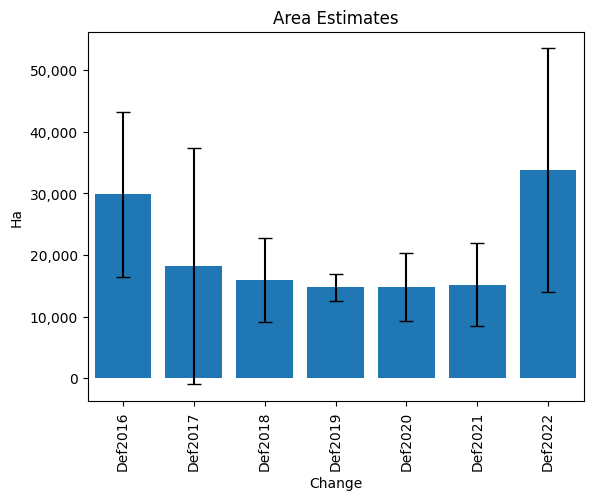

In [29]:
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
Def_areas = stats_calc_sorted[stats_calc_sorted['Change_Year'].isin(values_to_plot)]

# Create a bar chart
fig, ax = plt.subplots()
Def_areas.plot(kind='bar', x='Change_Year', y='area_total', legend=False, ax=ax)

# Define a custom formatting function for the y-axis labels
def format_thousands(x, pos):
    return f'{x:,.0f}'

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_thousands))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')

# Plot error bars with corresponding x values
plt.bar(Def_areas['Change_Year'], Def_areas['area_total'], yerr=Def_areas['MOE'], capsize=5, align='center')

# Show the plot
plt.show()

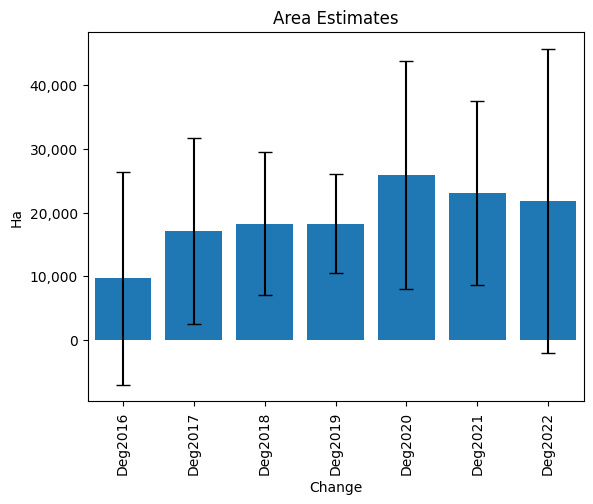

In [22]:
#plot DEG 
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
Deg_areas = stats_calc_sorted[stats_calc_sorted['Change_Year'].isin(values_to_plot)]

# Create a bar chart
fig, ax = plt.subplots()
Deg_areas.plot(kind='bar', x='Change_Year', y='area_total', legend=False, ax=ax)

# Define a custom formatting function for the y-axis labels
def format_thousands(x, pos):
    return f'{x:,.0f}'

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_thousands))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')

# Plot error bars with corresponding x values
plt.bar(Deg_areas['Change_Year'], Deg_areas['area_total'], yerr=Deg_areas['MOE'], capsize=5, align='center')

# Show the plot
plt.show()